# Title 

Talk about commercial airplanes, little bit of history, which airfoils I'll be comparing

Start with piston engine aircraft
* Douglas DC-7 (NACA 23016)
* Lockheed Constellation (NACA 23018)

while working: add push commit as usual

when done: pull request 

In [1]:
import os
import math
import numpy
from scipy import integrate
from matplotlib import pyplot

%matplotlib inline

## Classes classes classes!

In [10]:
class Panel:
    """
    Contains information related to a panel.
    """
    def __init__(self, xa, ya, xb, yb):
        """
        Initializes the panel.
        
        Sets the end-points and calculated the center, length, and angle 
        (with the x-axis) of the panel.
        Initializes the strength of the source-sheet, the tangential velocity,
        and the pressure coefficient to zero.
        
        Parameters
        ----------
        xa: float
            x-coordinate of the first end-point.
        ya: float
            y-coordinate of the first end-point.
        xb: float
            x-coordinate of the second end-point.
        yb: float
            y-coordinate of the second end-point.
        """
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, yb
        
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2        # control-point (center-point)
        self.length = math.sqrt((xb-xa)**2+(yb-ya)**2) # length of panel
        
        # orientation of the panel (angle between x-axis and panel's normal)
        if xb-xa <= 0.:
            self.beta = math.acos((yb-ya)/self.length)
        elif xb-xa > 0.:
            self.beta = math.pi + math.acos(-(yb-ya)/self.length)
            
        # location of the panel
        if self.beta <= math.pi:
            self.loc = 'upper'
        else:
            self.loc = 'lower'
            
        self.sigma = 0     # source strength
        self.vt = 0        # tangential velocity
        self.cp = 0        # pressure coefficient

In [3]:
class Freestream:
    """
    Freestream conditions.
    """
    def __init__(self, u_inf=1.0, alpha=0.0):
        """
        Sets the freestream speed and angle (with the x-axis).
        
        Parameters
        ----------
        u_inf: float, optional
            Freestream speed;
            default: 1.0.
        alpha: float, optional
            Angle of attach in degrees;
            default: 0.0.
        """
        self.u_inf = u_inf
        self.alpha = math.radians(alpha)

## Functions functions functions!

In [2]:
def define_panels(x, y, N=40):
    """
    Discretizes the geometry into panels using the 'cosine' method.
    
    Parameters
    ----------
    x: 1D array of floats
        x-coordinate of the points defining the geometry.
    y: 1D array of floats
        y-coordinate of the points defining the geometry.
    N integer, optional
        Number of panels;
        default: 40.
        
    Returns
    -------
    panels: 1D numpy array of Panel objects
        The discretization of the geometry into panels.
    """
    R = (x.max()-x.min())/2
    x_center = (x.max()+x.min())/2
    x_circle = x_center + R*numpy.cos(numpy.linspace(0, 2*math.pi, N+1))
    
    x_ends = numpy.copy(x_circle)
    y_ends = numpy.empty_like(x_ends)
    
    x, y = numpy.append(x, x[0]), numpy.append(y, y[0])
    
    # computes the y-coordinate of end-points
    I = 0
    for i in range(N):
        while I < len(x)-1:
            if (x[I] <= x_ends[i] <= x[I+1]) or (x[I+1] <= x_ends[i] <= x[I]):
                break
            else:
                I += 1
        a = (y[I+1]-y[I])/(x[I+1]-x[I])
        b = y[I+1]-a*x[I+1]
        y_ends[i] = a*x_ends[i] + b
    y_ends[N] = y_ends[0]
    
    panels = numpy.empty(N, dtype=object)
    for i in range(N):
        panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i+1], y_ends[i+1])
        
    return panels

In [5]:
def integral(x, y, panel, dxdz, dydz):
    """
    Evaluates the contribution of a panel at one point.
    
    Parameters
    ----------
    x: float 
        x_coordinate of the target point.
    y: float
        y_coordinate of the target point.
    panel: Panel object
        Source panel which contribution is evaluated.
    dxdz: float
        Derivative of x in the z-direction.
    dydz: float
        Derivative of y in the z-direction.
    
    Returns
    -------
    Integral over the panel of the influence at the given target point.
    """
    def integrand(s):
        return ( ((x - (panel.xa - math.sin(panel.beta)*s))*dxdz
                  +(y - (panel.ya + math.cos(panel.beta)*s))*dydz)
                / ((x - (panel.xa - math.sin(panel.beta)*s))**2
                   +(y - (panel.ya + math.cos(panel.beta)*s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

In [1]:
def source_contribution_normal(panels):
    """
    Builds the source contribution matrix for the normal velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    
    Returns
    -------
    A: 2D numpy array of floats
        Source contribution matrix.
    """
    A = numpy.empty((panels.size, panels.size), dtype=float)
    # source contribution on a panel from itself
    numpy.fill_diagonal(A, 0.5)
    # source contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i!=j:
                A[i,j] = 0.5/numpy.pi*integral(panel_i.xc, panel_i.yc,
                                               panel_j, numpy.cos(panel_i.beta),
                                               numpy.sin(panel_i.beta))
    return A

In [2]:
def vortex_contribution_normal(panels):
    """
    Builds the vortex contribution matrix for the normal velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
        
    Returns
    -------
    A: 2D numpy array of floats
        Vortex contribution matrix.
    """
    A = numpy.empty((panels.size, panels.size), dtype=float)
    # vortex contribution on a panel from itself
    numpy.fill_diagonal(A, 0.0)
    # vortex contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i!=j:
                A[i,j] = -0.5/numpy.pi*integral(panel_i.xc, panel_i.yc,
                                               panel_j, numpy.sin(panel_i.beta),
                                               -numpy.cos(panel_i.beta))
    return A

In [3]:
def kutta_condition(A_source, B_vortex):
    """
    Builds the Kutta condition array.
    
    Parameters
    ----------
    A_source: 2D numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D numpy array of floats
        Vortex contribution matrix for the normal velocity.
    
    Returns
    -------
    b: 1D numpy array of floats
        The left-hand side of the Kutta-condition equation.
    """
    b = numpy.empty(A_source.shape[0]+1, dtype=float)
    
    # matrix of source contribution on the tangential velocity 
    # is the same as the
    # matric of vortex contribution on normal velocity
    b[:-1] = B_vortex[0, :] + B_vortex[-1, :]
    
    # matrix of vortex contribution on tangential velocity
    # is the same as the
    # matrix of source contribution on normal velocity
    b[-1] = -numpy.sum(A_source[0, :] + A_source[-1, :])
    
    return b

In [4]:
def build_singularity_matrix(A_source, B_vortex):
    """
    Builds the left-hand side matrix of the system
    arising from souce and vortex contributions.
    
    Parameters
    ----------
    A_source: 2D numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D numpy array of floats
        Vortex contribution matrix for the normal velocity.
    
    Returns
    -------
    A: 2D numpy array of floats
        Matrix of the linear system.
    """
    A = numpy.empty((A_source.shape[0]+1, A_source.shape[1]+1), dtype=float)
    
    # source contribution matrix
    A[:-1, :-1] = A_source
    
    # vortex contribution array 
    # fill the last column of all rows but the last of A
    A[:-1, -1] = numpy.sum(B_vortex, axis=1)
    
    # Kutta condition array
    # fill all the columns in the last row of A
    A[-1, :] = kutta_condition(A_source, B_vortex)
    return A

In [5]:
def build_frestream_rhs(panels, freestream):
    """
    Builds the right-hand side of the system 
    arising from the freestream contribution.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    
    Returns
    -------
    b: 1D Numpy array of floats
        Freestream contribution on each panel and on the Kutta condition.
    """
    b = numpy.empty(panels.size+1, dtype=float)
    # freestream contribution on each panel
    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf*numpy.cos(freestream.alpha - panel.beta)
    # freestream contribution on the Kutta condition
    b[-1] = -freestream.u_inf*(numpy.sin(freestream.alpha-panels[0].beta)
                              +numpy.sin(freestream.alpha-panels[-1].beta))
    return b

In [6]:
def compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex):
    """
    Computes the tangential surface velocity.
    
    Parameters
    ----------
    panels: 1D array pf Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    gamma: float
        Circular density.
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocuty.
    """
    A = numpy.empty((panels.size, panels.size+1), dtype=float)
    
    # matrix of source contribution on tangential velocity
    # is the same as the
    # matrix of vortex contribution on normal velocity
    A[:, :-1] = B_vortex
    
    # matrix of vortex contribution on tangential velocity
    # is the opposite of the
    # matrix of source contribution on normal velocity
    A[:, -1] = -numpy.sum(A_source, axis=1)
    
    # freestream contribution
    b = freestream.u_inf*numpy.sin([freestream.alpha-panel.beta for panel in panels])
    
    strenghs = numpy.append([panel.sigma for panel in panels], gamma)
    tangential_velocities = numpy.dot(A, strengths) + b
    
    for i, panel in enumerate(panels):
        panel.vt = tangential_velocities[i]

In [7]:
def compute_pressure_coefficient(panels, freestream):
    """
    Computes the surface pressure coefficients.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    """
    for panel in panels:
        panel.cp = 1.0 - (panel.vt/freestream.u_inf)**2

## Load load load!

In [5]:
foil1x, foil1y = numpy.loadtxt("Douglas_DC-7.txt",dtype=float,unpack=True)

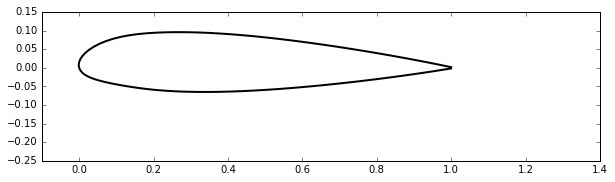

In [7]:
size = 10
pyplot.figure(figsize=(size, size))
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.1, 1.4)
pyplot.ylim(-0.25, 0.15)
pyplot.plot(foil1x, foil1y, color='k', linestyle='-', linewidth=2);

In [8]:
def define_panels(x, y):
    """
    Creates panels form discretized geometry.
    
    Parameters
    x: 1D array of floats
        x-coordinate of the points defining the geometry.
    y: 1D array of floats
        y-coordinate of the points defining the geometry.
    
    Returns
    -------
    panels: 1D numpy array of Panel objects
        The list of panels.
    """
    N = len(x)-1
    x_ends, y_ends = x, y
    panels = numpy.empty(N, dtype=object)
    for i in range(N):
        panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i+1], y_ends[i+1])
        
    return panels

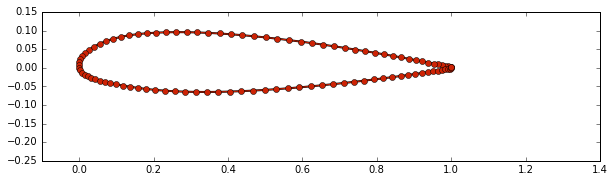

In [13]:
panels = define_panels(foil1x, foil1y)

size = 10
pyplot.figure(figsize=(size, size))
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.1, 1.4)
pyplot.ylim(-0.25, 0.15)
pyplot.plot(foil1x, foil1y, color='k', linestyle='-', linewidth=2)
pyplot.plot(numpy.append([panel.xa for panel in panels], panels[0].xa),
            numpy.append([panel.ya for panel in panels], panels[0].ya),
            linestyle='-', linewidth=1, marker='o', markersize=6, color='#CD2305');